In [1]:
from scipy import misc
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import pywt
import heapq
from collections import defaultdict
import os

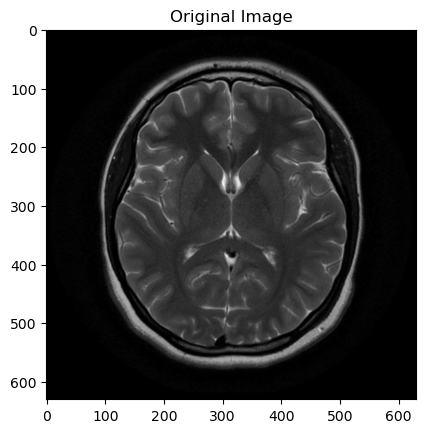

In [2]:


import imageio.v2 as imageio
# Load image into variable and display it
lion = imageio.imread("D:\\Image Compression Web\\Dataset\\images\\trainB\\mri7.jpg")# Escaping backslashes
plt.imshow(lion, cmap=plt.get_cmap('gray'))
plt.title("Original Image")
plt.show()



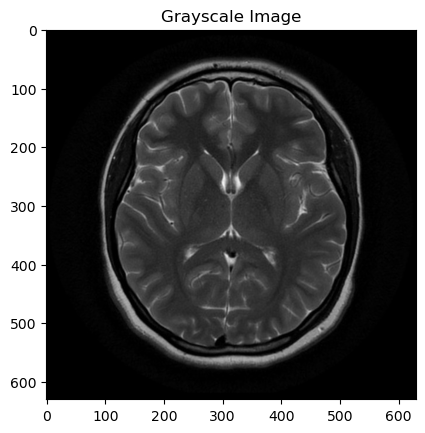

In [3]:
# Convert color image to grayscale
lion_gray = np.dot(lion[..., :3], [0.299, 0.587, 0.114])
plt.imshow(lion, cmap=plt.get_cmap('gray'))
plt.title("Grayscale Image")
plt.show()


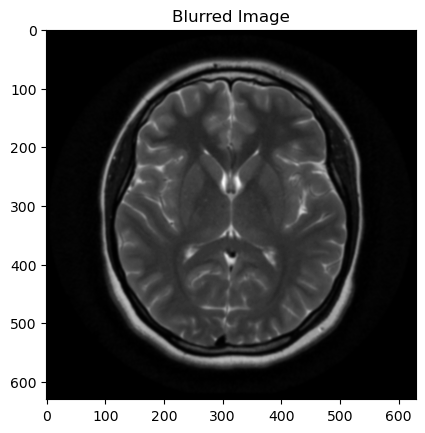

In [4]:
# Blur the grayscale image
lion_gray_blurred = ndimage.gaussian_filter(lion_gray, sigma=1.4)
plt.imshow(lion_gray_blurred, cmap=plt.get_cmap('gray'))
plt.title("Blurred Image")
plt.show()

In [5]:
# Apply Sobel Filter using the convolution operation
# Note that in this case I have used the filter to have a maximum amgnitude of 2, but it can also be changed to other numbers for aggressive edge extraction
# For eg [-1,0,1], [-5,0,5], [-1,0,1]
def SobelFilter(img, direction):
    if(direction == 'x'):
        Gx = np.array([[-1,0,+1], [-2,0,+2],  [-1,0,+1]])
        Res = ndimage.convolve(img, Gx)
        #Res = ndimage.convolve(img, Gx, mode='constant', cval=0.0)
    if(direction == 'y'):
        Gy = np.array([[-1,-2,-1], [0,0,0], [+1,+2,+1]])
        Res = ndimage.convolve(img, Gy)
        #Res = ndimage.convolve(img, Gy, mode='constant', cval=0.0)
    
    return Res

In [6]:
# Normalize the pixel array, so that values are <= 1
def Normalize(img):
    #img = np.multiply(img, 255 / np.max(img))
    img = img/np.max(img)
    return img

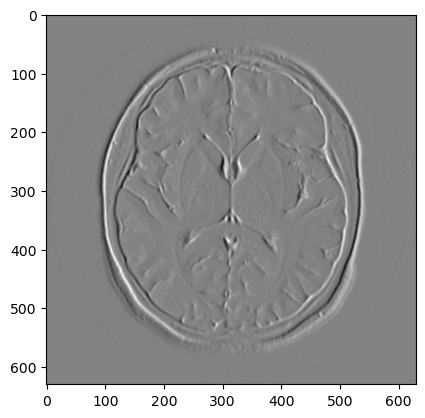

In [7]:
# Apply Sobel Filter in X direction
gx = SobelFilter(lion_gray_blurred, 'x')
gx = Normalize(gx)
plt.imshow(gx, cmap = plt.get_cmap('gray'))
plt.show()

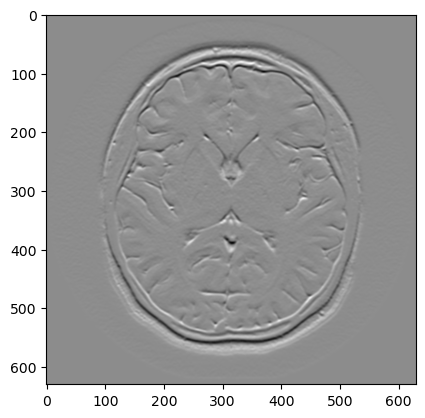

In [8]:
# Apply Sobel Filter in Y direction
gy = SobelFilter(lion_gray_blurred, 'y')
gy = Normalize(gy)
plt.imshow(gy, cmap = plt.get_cmap('gray'))
plt.show()

In [9]:
dx = ndimage.sobel(lion_gray_blurred, axis=1) # horizontal derivative
dy = ndimage.sobel(lion_gray_blurred, axis=0) # vertical derivative

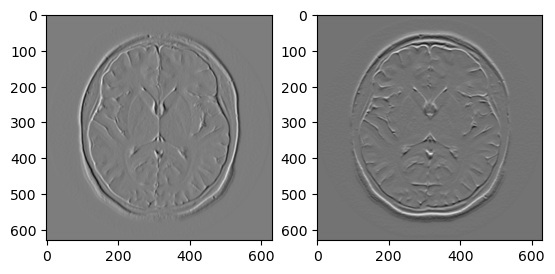

In [10]:
# Plot the derivative filter values obtained using the inbuilt function
plt.subplot(121)
plt.imshow(dx, cmap = plt.get_cmap('gray'))
plt.subplot(122)
plt.imshow(dy, cmap = plt.get_cmap('gray'))
plt.show()

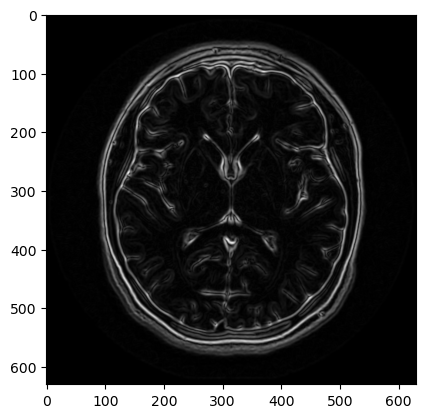

In [11]:
# Calculate the magnitude of the gradients obtained
Mag = np.hypot(gx,gy)
Mag = Normalize(Mag)
plt.imshow(Mag, cmap = plt.get_cmap('gray'))
plt.show()

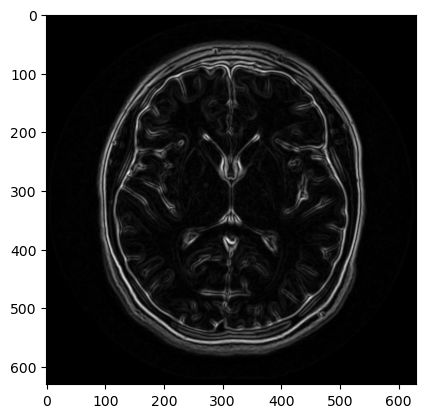

In [12]:
# Calculate the magnitude of the gradients obtained using the inbuilt function, again done to verify the correctness of the above value
mag = np.hypot(dx,dy)
mag = Normalize(mag)
plt.imshow(mag, cmap = plt.get_cmap('gray'))
plt.show()

In [13]:
# Calculate direction of the gradients
Gradient = np.degrees(np.arctan2(gy,gx))

In [14]:
# Calculate the direction of the gradients obtained using the inbuilt sobel function
gradient = np.degrees(np.arctan2(dy,dx))

In [15]:
# Do Non Maximum Suppression with interpolation to get a better estimate of the magnitude values of the pixels in the gradient direction
# This is done to get thin edges
def NonMaxSupWithInterpol(Gmag, Grad, Gx, Gy):
    NMS = np.zeros(Gmag.shape)
    
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= 0 and Grad[i,j] <= 45) or (Grad[i,j] < -135 and Grad[i,j] >= -180)):
                yBot = np.array([Gmag[i,j+1], Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i,j-1], Gmag[i-1,j-1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 45 and Grad[i,j] <= 90) or (Grad[i,j] < -90 and Grad[i,j] >= -135)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j-1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 90 and Grad[i,j] <= 135) or (Grad[i,j] < -45 and Grad[i,j] >= -90)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 135 and Grad[i,j] <= 180) or (Grad[i,j] < 0 and Grad[i,j] >= -45)):
                yBot = np.array([Gmag[i,j-1] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i,j+1] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
    
    return NMS
                
            

In [16]:
# This is also non-maxima suppression but without interpolation i.e. the pixel closest to the gradient direction is used as the estimate
def NonMaxSupWithInterpol(Gmag, Grad, Gx, Gy):
    NMS = np.zeros(Gmag.shape)
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if Gmag[i, j] == 0:
                NMS[i, j] = 0
            else:
                if Grad[i, j] == 0:
                    x_est = 0
                    y_est = 0
                else:
                    x_est = np.absolute(Gx[i, j] / Gmag[i, j])
                    y_est = np.absolute(Gy[i, j] / Gmag[i, j])

                if (0 <= Grad[i, j] < 22.5) or (157.5 <= Grad[i, j] <= 180):
                    if (Gmag[i, j] > Gmag[i, j + 1]) and (Gmag[i, j] > Gmag[i, j - 1]):
                        NMS[i, j] = Gmag[i, j]
                    else:
                        NMS[i, j] = 0
                if (22.5 <= Grad[i, j] < 67.5) or (-157.5 <= Grad[i, j] < -112.5):
                    if (Gmag[i, j] > Gmag[i + 1, j + 1]) and (Gmag[i, j] > Gmag[i - 1, j - 1]):
                        NMS[i, j] = Gmag[i, j]
                    else:
                        NMS[i, j] = 0
                if (67.5 <= Grad[i, j] < 112.5) or (-112.5 <= Grad[i, j] < -67.5):
                    if (Gmag[i, j] > Gmag[i + 1, j]) and (Gmag[i, j] > Gmag[i - 1, j]):
                        NMS[i, j] = Gmag[i, j]
                    else:
                        NMS[i, j] = 0
                if (112.5 <= Grad[i, j] < 157.5) or (-67.5 <= Grad[i, j] < -22.5):
                    if (Gmag[i, j] > Gmag[i + 1, j - 1]) and (Gmag[i, j] > Gmag[i - 1, j + 1]):
                        NMS[i, j] = Gmag[i, j]
                    else:
                        NMS[i, j] = 0

    return NMS

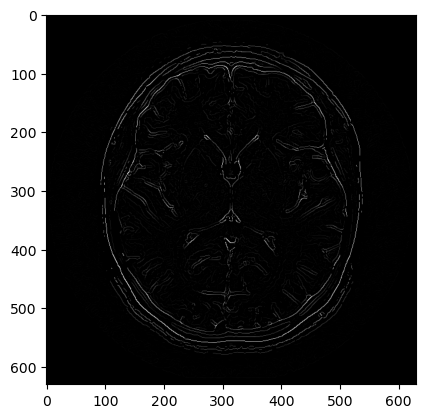

In [17]:
# Get the Non-max suppressed output
nms = NonMaxSupWithInterpol(mag, gradient, dx, dy)
nms = np.nan_to_num(nms)  # Replace NaN with zero
nms = Normalize(nms)  # Assuming Normalize function is defined elsewhere
plt.imshow(nms, cmap=plt.get_cmap('gray'))
plt.show()

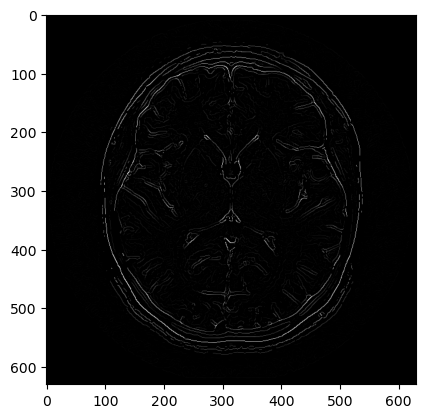

In [18]:
# Get the Non-max suppressed output on the same image but using the image using the inbuilt sobel operator
nms = NonMaxSupWithInterpol(mag, gradient, dx, dy)
nms = Normalize(nms)
plt.imshow(nms, cmap = plt.get_cmap('gray'))
plt.show()

In [19]:
# Double threshold Hysterisis

def DoThreshHyst(img):
    highThresholdRatio = 0.2  
    lowThresholdRatio = 0.15 
    GSup = np.copy(img)
    h = int(GSup.shape[0])
    w = int(GSup.shape[1])
    highThreshold = np.max(GSup) * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio    
    x = 0.1
    oldx=0
    
    # The while loop is used so that the loop will keep executing till the number of strong edges do not change, i.e all weak edges connected to strong edges have been found
    while(oldx != x):
        oldx = x
        for i in range(1,h-1):
            for j in range(1,w-1):
                if(GSup[i,j] > highThreshold):
                    GSup[i,j] = 1
                elif(GSup[i,j] < lowThreshold):
                    GSup[i,j] = 0
                else:
                    if((GSup[i-1,j-1] > highThreshold) or 
                        (GSup[i-1,j] > highThreshold) or
                        (GSup[i-1,j+1] > highThreshold) or
                        (GSup[i,j-1] > highThreshold) or
                        (GSup[i,j+1] > highThreshold) or
                        (GSup[i+1,j-1] > highThreshold) or
                        (GSup[i+1,j] > highThreshold) or
                        (GSup[i+1,j+1] > highThreshold)):
                        GSup[i,j] = 1
        x = np.sum(GSup == 1)
    
    GSup = (GSup == 1) * GSup # This is done to remove/clean all the weak edges which are not connected to strong edges
    
    return GSup
                

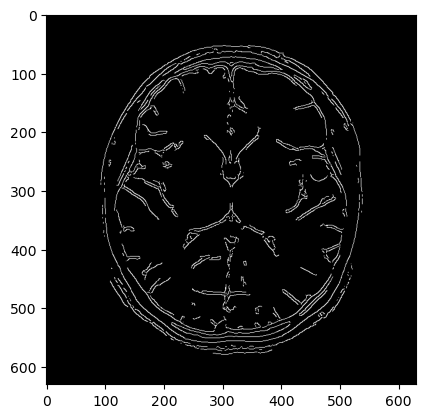

In [20]:
# canny edge detection 
Final_Image = DoThreshHyst(nms)
plt.imshow(Final_Image, cmap = plt.get_cmap('gray'))
plt.show()

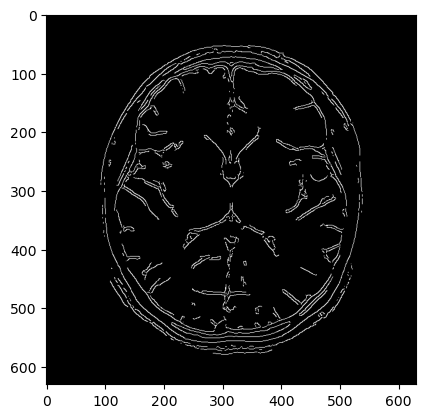

In [21]:

final_image = DoThreshHyst(nms)
plt.imshow(final_image, cmap = plt.get_cmap('gray'))
plt.savefig('mri7.jpg')
plt.show()

In [22]:
# Function to perform Discrete Wavelet Transform (DWT) on 3D image data
def dwt_3d(image, wavelet='haar', level=1):
    coeffs = pywt.wavedecn(image, wavelet, level=level)
    return coeffs

final_image = DoThreshHyst(nms)

# Perform DWT on the 3D image data
coeffs = dwt_3d(final_image)
print("DWT completed.")


DWT completed.


In [23]:
#Flatten the coefficients for compression
flattened_coeffs = np.concatenate([np.array(arr).flatten() for arr in coeffs])

# Convert the flattened coefficients to bytes
bytes_data = flattened_coeffs.tobytes()



In [24]:
# Function to perform lossless compression using Huffman coding
def huffman_encode(data):
    freq = defaultdict(int)
    for symbol in data:
        freq[symbol] += 1
    heap = [[weight, [symbol, ""]] for symbol, weight in freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return dict(heapq.heappop(heap)[1:])

# Encode the bytes data using Huffman coding
huffman_encoded_data = huffman_encode(bytes_data)
print("Huffman encoding completed.")


Huffman encoding completed.


In [25]:
# Print the compression ratio
compression_ratio = len(huffman_encoded_data) / len(bytes_data)
print("Compression ratio:", compression_ratio)

# Print the compression ratio as percentage
compression_ratio_percentage = (1 - len(huffman_encoded_data) / len(bytes_data)) * 100
print("Compression ratio (%):", compression_ratio_percentage)


Compression ratio: 0.00032249611996855665
Compression ratio (%): 99.96775038800314


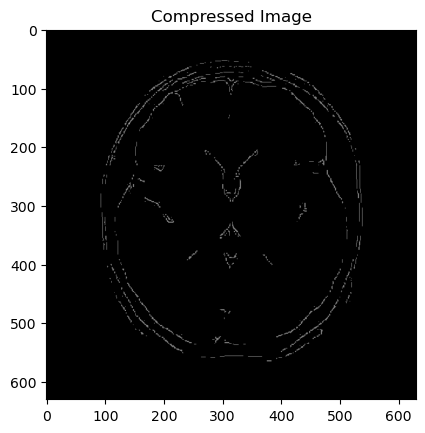

In [26]:
import cv2

# Assuming you have your grayscale image in lion_gray_blurred
# Convert to uint8
lion_gray_blurred_uint8 = lion_gray_blurred.astype(np.uint8)

# Perform Canny edge detection
edges_canny = cv2.Canny(lion_gray_blurred_uint8, 100, 200)  # Adjust thresholds as needed

# Convert the image to uint8 format
edges_canny_uint8 = (edges_canny * 255).astype(np.uint8)

# Save compressed image
compressed_image_path = "compressed image.jpg"
cv2.imwrite(compressed_image_path, edges_canny_uint8)




# Load and display the compressed image
compressed_image = imageio.imread(compressed_image_path)
plt.imshow(compressed_image, cmap=plt.get_cmap('gray'))
plt.title("Compressed Image")
plt.show()



In [27]:
# Get the file sizes of original and compressed images
original_image_size = os.path.getsize("D:\\Image Compression Web\\Dataset\\images\\trainB\\mri7.jpg")
compressed_image_size = os.path.getsize(compressed_image_path)

In [28]:
# Calculate the compression ratio
compression_ratio_bytes = original_image_size / compressed_image_size


In [29]:
# Display the comparison
print("Original image size:", original_image_size, "bytes")
print("Compressed image size:", compressed_image_size, "bytes")
print("Compression ratio (bytes):", compression_ratio_bytes)

Original image size: 55697 bytes
Compressed image size: 6726 bytes
Compression ratio (bytes): 8.280850431162653


In [30]:

# Define the thresholding function
def threshold(coeffs, threshold_value):
    # Threshold all the detail coefficients
    for i in range(1, len(coeffs)):
        key = 'd' + str(i)
        if isinstance(coeffs, dict) and key in coeffs:
            coeffs[key] = tuple(
                pywt.threshold(arr, value=threshold_value, mode='hard') for arr in coeffs[key]
            )
    return coeffs

In [31]:
# Apply thresholding to the coefficients
threshold_value = 20  # Adjust as needed
thresholded_coeffs = threshold(coeffs, threshold_value)

In [32]:
# Convert list of coefficients to a dictionary
thresholded_coeffs_dict = {}
for i, arr in enumerate(thresholded_coeffs):
    key = 'd' + str(i) if i > 0 else 'a'
    thresholded_coeffs_dict[key] = arr

In [33]:
def idwt_3d(coeffs, wavelet='haar'):
    image = pywt.waverecn(coeffs, wavelet)
    return image


In [34]:
# Perform inverse DWT to reconstruct the image
reconstructed_image = idwt_3d(coeffs)
print("Image reconstruction completed.")




Image reconstruction completed.


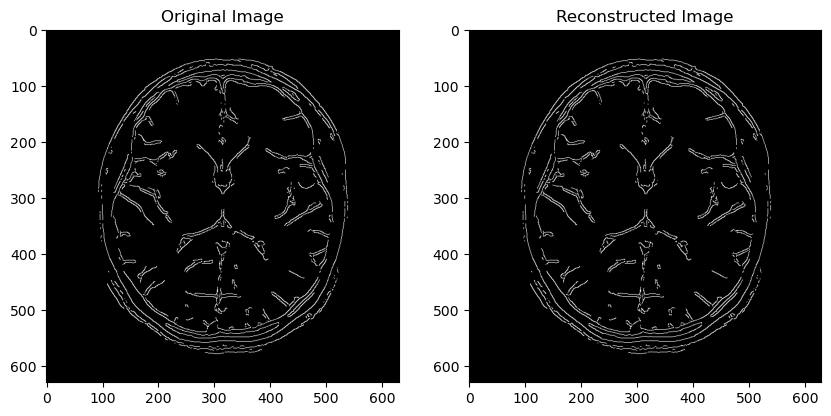

In [35]:
# Display the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(final_image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.show()

In [36]:
import numpy as np

def psnr(original_image, reconstructed_image):
    # Ensure images are of type float64
    original_image = original_image.astype(np.float64)
    reconstructed_image = reconstructed_image.astype(np.float64)
    
    # Resize the reconstructed image to match the shape of the original image
    reconstructed_image = np.resize(reconstructed_image, original_image.shape)
    
    # Print shapes and image properties for debugging
    print("Original image shape:", original_image.shape)
    print("Reconstructed image shape:", reconstructed_image.shape)
    print("Original image min/max:", np.min(original_image), "/", np.max(original_image))
    print("Reconstructed image min/max:", np.min(reconstructed_image), "/", np.max(reconstructed_image))
    
    # Calculate MSE
    mse = np.mean((original_image - reconstructed_image) ** 2)
    
    # Calculate PSNR
    if mse == 0:
        return "Infinite"
    max_pixel = np.max(original_image)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def mse(original_image, reconstructed_image):
    # Ensure images are of type float64
    original_image = original_image.astype(np.float64)
    reconstructed_image = reconstructed_image.astype(np.float64)
    
    # Resize the reconstructed image to match the shape of the original image
    reconstructed_image = np.resize(reconstructed_image, original_image.shape)
    
    # Calculate MSE
    mse = np.mean((original_image - reconstructed_image) ** 2)
    return mse

# Assuming you have 'lion_gray' as the original grayscale image and 'reconstructed_image' as the reconstructed image
psnr_value = psnr(lion_gray, reconstructed_image)
mse_value = mse(lion_gray, reconstructed_image)

print("PSNR:", psnr_value)
print("MSE:", mse_value)


Original image shape: (630, 630)
Reconstructed image shape: (630, 630)
Original image min/max: 0.0 / 248.0
Reconstructed image min/max: 0.0 / 1.0000000000000004
PSNR: 14.46719379589867
MSE: 2198.7911589821115


In [ ]:
import cv2

# Function to display image in a region of interest (ROI) selector
def select_roi(image):
    # Display the image
    cv2.imshow('Select ROI', image)
    
    # Initialize the ROI selector
    roi = cv2.selectROI("Select ROI", image)
    
    # Crop the image based on the selected ROI
    cropped_image = image[int(roi[1]):int(roi[1] + roi[3]), int(roi[0]):int(roi[0] + roi[2])]
    
    # Close the ROI selector window
    cv2.destroyAllWindows()
    
    return cropped_image

# Display the reconstructed image
cropped_reconstructed_image = select_roi(reconstructed_image)

# Save the cropped image
cv2.imwrite('cropped_reconstructed_image.jpg', cropped_reconstructed_image)

# Display the cropped image
cv2.imshow('Cropped Reconstructed Image', cropped_reconstructed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

